# Figures for UT-LVCE as a causal discovery procedure

### i.e. Figures 4, 7, 8 and 9

In [1]:
import numpy as np
import sempler
import sempler.generators

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.lines import Line2D

import pickle
import os

import ut_lvcm.utils as utils
import ut_lvcm.metrics

/home/juan/anaconda3/lib/python3.7/site-packages/rpy2/robjects/vectors.py:1008: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '
/home/juan/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1858: PytzUsageWarning: The zone attribute is specific to pytz's interface; please migrate to a new time zone provider. For more details on how to do so, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  values, tz_parsed = conversion.datetime_to_datetime64(data)


/home/juan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  # Remove the CWD from sys.path while we load stuff.


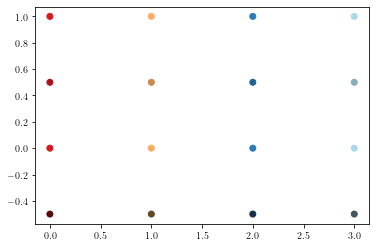

In [2]:
# Set tex formatting for plots
from matplotlib import rc
#rc('font',**{'family':'serif','sans-serif':['Computer Modern Roman']})
rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble'] = [
       r'\usepackage{siunitx}',   # i need upright \micro symbols, but you need...
       r'\sisetup{detect-all}',   # ...this to force siunitx to actually use your fonts
       r'\usepackage{helvet}',    # set the normal font here
       r'\usepackage{sansmath}',  # load up the sansmath so that math -> helvet
       r'\sansmath'               # <- tricky! -- gotta actually tell tex to use!
]  
#plt.rcParams["font.family"] = "serif"
#plt.rcParams["font.serif"] = ["Computer Modern Roman"]

# Set legend size
from matplotlib.font_manager import FontProperties
fontP = FontProperties()
fontP.set_size('small')

# Colors
def to_rgb(H, b=1, a=1, w=0):
    RGBa = []
    for h in H:
        h = h.lstrip("#")
        RGBa.append(tuple(min(1,int(h[i:i+2], 16) / 256 * b + w) for i in (0, 2, 4)) + (a,))
    return np.array(RGBa)

cmap = matplotlib.cm.get_cmap('tab20')
base = ['#d7191c', '#fdae61', '#2c7bb6', '#abd9e9']
plt.scatter(np.arange(len(base)), np.ones(len(base)), c = base)
colors = to_rgb(base)
colorsa = to_rgb(base, b=0.8)
colorsb = to_rgb(base, b=0.4)
plt.scatter(np.arange(len(colors)), np.zeros(len(colors)), c = colors)
plt.scatter(np.arange(len(colors)), np.ones(len(colors))*0.5, c = colorsa)
plt.scatter(np.arange(len(colors)), np.ones(len(colors))*-0.5, c = colorsb)

In [3]:
def read_result(filename):
    if os.path.getsize(filename) > 0:
        with open(filename, "rb") as f:
            return pickle.load(f)

In [4]:
methods = ["ut_lvce", "backshift", "causal_dantzig", "lrps"]
names = ["UT-LVCE", "backShift", "Causal Dantzig", "LRPS+GES"]
disp_names = {"UT-LVCE": "GES+UT-LVCE",
              "backShift": "backShift",
              "Causal Dantzig": "Causal Dantzig",
              "LRPS+GES": "LRPS+GES"}
names_methods = list(zip(names,methods))

In [5]:
def process_results(all_files, what='parents', debug=False, exclude=[]):
    # Iterate over intervention sizes
    values = {}
    supergraphs = {}
    size_initial = {}
    for i,files_size_I in enumerate(all_files):  
        # Iterate over sample sizes
        dict_Ns = {}
        supergraphs_Ns = {}
        size_initial_Ns = {}
        for j,file_n in enumerate(files_size_I):
            args, test_cases, results = read_result(file_n)
            # Check that intervention size is consistent
            if j == 0:
                size_I = args.size_I
                print("  |I^\star| =", size_I) if debug else None
            if j > 0:
                assert size_I == args.size_I
            # Iterate over methods            
            dict_methods = {}            
            print("    n =", args.n) if debug else None
            # If looking at parent estimates                        
            if what=='parents':                                
                for (name,method) in names_methods:
                    if name in exclude:
                        continue
                    print("      method =", name) if debug else None
                    t1 = np.array(results['t1_%s' % method])
                    t2 = np.array(results['t2_%s' % method])
                    # Store results for this method
                    dict_methods[name] = (t1,t2)
            # If looking at I-MEC estimates            
            elif what=='graphs':
                truth = [utils.imec(m.A, I) for m,I in test_cases]
                estimates = {}
                if 'LRPS+GES' not in exclude:
                    estimates['LRPS+GES'] = [utils.all_dags(cpdag) for cpdag in results['graphs_lrps']]
                if 'backShift' not in exclude:
                    estimates['backShift'] = [[A] for A in results['graphs_backshift']]
                if 'UT-LVCE' not in exclude:
                    estimates['UT-LVCE'] = [utils.imec(m.A,I) for (m,I,_),_ in results['ut_lvce_output']]
                    # Count instances of GES upergraphs for binning
                    all_initial_graphs = [h['initial_graphs'] for _,h in results['ut_lvce_output']]
                    counts = np.zeros(len(truth))
                    sizes = np.zeros(len(truth))
                    for j,(true_imec,initial_graphs) in enumerate(zip(truth,all_initial_graphs)):
                        sizes[j] = len(initial_graphs)
                        for A0 in initial_graphs:
                            if np.array([utils.is_supergraph(A0, A) for A in true_imec]).any():
                                 counts[j] += 1
                    supergraphs_Ns[args.n] = counts
                    size_initial_Ns[args.n] = sizes
                for name in [name for name in names if name not in exclude + ['Causal Dantzig']]:
                    print("      method =", name) if debug else None
                    t1 = np.zeros(len(truth))
                    t2 = np.zeros(len(truth))
                    for j, true_imec in enumerate(truth):
                        t1[j] = ut_lvcm.metrics.type_1_structc(estimates[name][j], true_imec)
                        t2[j] = ut_lvcm.metrics.type_2_structc(estimates[name][j], true_imec)
                    dict_methods[name] = (t1, t2)
            # Store results for this sample size
            dict_Ns[args.n] = dict_methods            
        # Store results for this intervention size
        values[size_I] = dict_Ns
        supergraphs[size_I] = supergraphs_Ns
        size_initial[size_I] = size_initial_Ns
    return values, supergraphs, size_initial

In [6]:
def plot_roc_I(ax,values,mean=True,label_y=False,label_x=True,xticks=None,legend=None):
    # Parameters
    method_markers = {
        "UT-LVCE": {'fillstyle': 'right', 'markerfacecolor': colors[0], 'markerfacecoloralt': colorsa[0], 'markeredgecolor': colorsb[0]},
        "backShift": {'fillstyle': 'full', 'markerfacecolor': colors[1], 'markerfacecoloralt': colorsa[1], 'markeredgecolor': colorsb[1]},
        "Causal Dantzig": {'fillstyle': 'full', 'markerfacecolor': colors[2], 'markerfacecoloralt': colorsa[2], 'markeredgecolor': colorsb[2]},
        "LRPS+GES": {'fillstyle': 'top', 'markerfacecolor': colors[3], 'markerfacecoloralt': colorsa[3], 'markeredgecolor': colorsb[3]}
    }
    markers_n = dict(zip([100,500,1000,10000], ['D', 'o', 'X', '.']))
    yticks = [0, 0.2, 0.4, 0.6, 0.8, 1]    
    # Plot
    used_ns, used_methods = set(), set()   
    for n, dict_n in values.items():
        used_ns.add(n)
        for name, (t1,t2) in dict_n.items():
            used_methods.add(name)
            x, y = (t1.mean(),1-t2.mean()) if mean else (t1, 1-t2)
            ax.plot(x, y,
                    marker=markers_n[n],
                    markersize=9,
                    zorder=10 + n,
                    clip_on=False,
                    markeredgewidth=0.7,
                    **method_markers[name])
    # Compose legend
    if legend is not None:
        used_ns = sorted(used_ns)

        # Methods
        method_entries = [Line2D([0], [0],                                 
                                 linestyle='None',
                                 marker='s',
                                 markersize=8,
                                 **method_markers[name]) for name in used_methods]
        method_strings = [disp_names[name] for name in used_methods]
        # n
        sample_size_entries = [Line2D([0], [0], linestyle='None', color='gray', marker=markers_n[n]) for n in used_ns]
        sample_size_strings = ["$n = %d$" % n for n in used_ns]
        # Putting it all together
        entries = method_entries + sample_size_entries
        strings = method_strings + sample_size_strings
        pos, ncol = legend
        ax.legend(entries, strings, bbox_to_anchor=pos, ncol=ncol)#len(entries))
    
    # Other formatting
    #ax.set_ylim(lim)
    #ax.set_xlim(lim)    
    if xticks is not None:
        ax.set_xticks(xticks)
    if label_x:
        ax.set_xlabel("avg. FDP")
        ax.set_xticklabels(xticks)
    ax.set_yticks(yticks)
    ax.set_yticklabels([])
    ax.set_ylim([-0.04, 1.04])
    if label_y:        
        ax.set_yticklabels(yticks)
        ax.set_ylabel("avg. TDP")        

## Figure 4

In [8]:
files_hs = [
[
"comparison_experiments/results_1690220084__cluster:1_seed:42_tag:fffchs_disc:15_runs:10_m:ubil_min_parents:2_G:50_k:2.1_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:2_e:5_size_I:10_it:0_sl:0_n:1000/compiled_results.pickle",
"comparison_experiments/results_1690220088__cluster:1_seed:42_tag:fffchs_disc:15_runs:10_m:ubil_min_parents:2_G:50_k:2.1_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:2_e:5_size_I:10_it:0_sl:0_n:500/compiled_results.pickle",
"comparison_experiments/results_1690220093__cluster:1_seed:42_tag:fffchs_disc:15_runs:10_m:ubil_min_parents:2_G:50_k:2.1_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:2_e:5_size_I:10_it:0_sl:0_n:100/compiled_results.pickle",
],[
"comparison_experiments/results_1690220099__cluster:1_seed:42_tag:fffchs_disc:15_runs:10_m:ubil_min_parents:2_G:50_k:2.1_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:2_e:5_size_I:19_it:0_sl:0_n:500/compiled_results.pickle",
"comparison_experiments/results_1690220090__cluster:1_seed:42_tag:fffchs_disc:15_runs:10_m:ubil_min_parents:2_G:50_k:2.1_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:2_e:5_size_I:19_it:0_sl:0_n:100/compiled_results.pickle",
"comparison_experiments/results_1690220204__cluster:1_seed:42_tag:fffchs_disc:15_runs:10_m:ubil_min_parents:2_G:50_k:2.1_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:2_e:5_size_I:19_it:0_sl:0_n:1000/compiled_results.pickle",
],[
"comparison_experiments/results_1690220114__cluster:1_seed:42_tag:fffchs_disc:15_runs:10_m:ubil_min_parents:2_G:50_k:2.1_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:2_e:5_size_I:20_it:1_sl:0_n:500/compiled_results.pickle",
"comparison_experiments/results_1690220117__cluster:1_seed:42_tag:fffchs_disc:15_runs:10_m:ubil_min_parents:2_G:50_k:2.1_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:2_e:5_size_I:20_it:1_sl:0_n:100/compiled_results.pickle",
"comparison_experiments/results_1690220118__cluster:1_seed:42_tag:fffchs_disc:15_runs:10_m:ubil_min_parents:2_G:50_k:2.1_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:2_e:5_size_I:20_it:1_sl:0_n:1000/compiled_results.pickle",
]]

In [9]:
values_parents,_,_ = process_results(files_hs, debug=False, what='parents')
values_graphs,_,_  = process_results(files_hs, debug=True, what='graphs')

  |I^\star| = 10
    n = 1000
      method = UT-LVCE
      method = backShift
      method = LRPS+GES
    n = 500
      method = UT-LVCE
      method = backShift
      method = LRPS+GES
    n = 100
      method = UT-LVCE
      method = backShift
      method = LRPS+GES
  |I^\star| = 19
    n = 500
      method = UT-LVCE
      method = backShift
      method = LRPS+GES
    n = 100
      method = UT-LVCE
      method = backShift
      method = LRPS+GES
    n = 1000
      method = UT-LVCE
      method = backShift
      method = LRPS+GES
  |I^\star| = 20
    n = 500
      method = UT-LVCE
      method = backShift
      method = LRPS+GES
    n = 100
      method = UT-LVCE
      method = backShift
      method = LRPS+GES
    n = 1000
      method = UT-LVCE
      method = backShift
      method = LRPS+GES


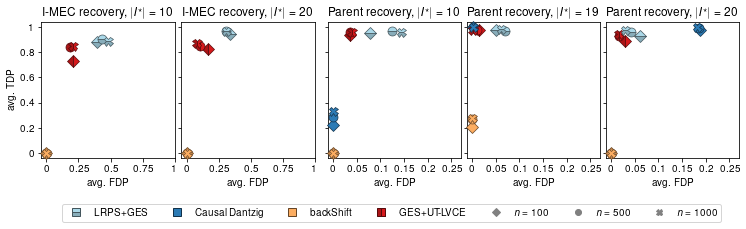

In [10]:
w = 2.5
plt.figure(figsize=(5*w,w))
outer = gridspec.GridSpec(1, 2, wspace=0.04, width_ratios=[2/5, 3/5], hspace=0)
inner1 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec = outer[0], wspace=0.05)
inner2 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec = outer[1], wspace=0.05)

# Plot 1
I = 10
plt.subplot(inner1[0])
ax = plt.gca()
plot_roc_I(ax, values_graphs[I], label_y=True, xticks=[0, 0.25, 0.5, 0.75, 1])
ax.set_title("I-MEC recovery, $|I^\star|=%d$" % I)
ax.set_xlim([-0.04, 1])

# Plot 2
I = 20
plt.subplot(inner1[1])
ax = plt.gca()
plot_roc_I(ax, values_graphs[I], xticks=[0, 0.25, 0.5, 0.75, 1])
ax.set_title("I-MEC recovery, $|I^\star|=%d$" % I)
ax.set_xlim([-0.04, 1])

# Plot 3
I = 10
plt.subplot(inner2[0])
ax = plt.gca()
plot_roc_I(ax, values_parents[I], xticks=[0, 0.05, 0.1, 0.15, 0.2, 0.25])
ax.set_title("Parent recovery, $|I^\star|=%d$" % I)
ax.set_xlim([-0.01, 0.27])

# Plot 4
I = 19
plt.subplot(inner2[1])
ax = plt.gca()
plot_roc_I(ax, values_parents[I], xticks=[0, 0.05, 0.1, 0.15, 0.2, 0.25])
ax.set_title("Parent recovery, $|I^\star|=%d$" % I)
ax.set_xlim([-0.01, 0.27])

# Plot 5
I = 20
plt.subplot(inner2[2])
ax = plt.gca()
plot_roc_I(ax, values_parents[I], xticks=[0, 0.05, 0.1, 0.15, 0.2, 0.25], legend=((0.9,-0.3),8))
ax.set_title("Parent recovery, $|I^\star|=%d$" % I)
ax.set_xlim([-0.01, 0.27])


# Save plot
plt.savefig("figures/figure_comparisons_all.pdf", bbox_inches='tight')

## Figure 9: violations of the Causal Dantzig assumptions

In [14]:
files_sh = [[
"comparison_experiments/results_1690221725__cluster:1_seed:42_tag:fffcsh_disc:15_runs:10_m:ubil_min_parents:2_G:50_k:2.1_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:3.0_i_v_hi:6.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:1.0_i_psi_hi:5.0_h:2_e:5_size_I:19_it:0_sl:0_n:100/compiled_results.pickle",
"comparison_experiments/results_1690221927__cluster:1_seed:42_tag:fffcsh_disc:15_runs:10_m:ubil_min_parents:2_G:50_k:2.1_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:3.0_i_v_hi:6.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:1.0_i_psi_hi:5.0_h:2_e:5_size_I:19_it:0_sl:0_n:500/compiled_results.pickle",
"comparison_experiments/results_1690222063__cluster:1_seed:42_tag:fffcsh_disc:15_runs:10_m:ubil_min_parents:2_G:50_k:2.1_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:3.0_i_v_hi:6.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:1.0_i_psi_hi:5.0_h:2_e:5_size_I:19_it:0_sl:0_n:1000/compiled_results.pickle",
"comparison_experiments/results_1690222068__cluster:1_seed:42_tag:fffcsh_disc:15_runs:10_m:ubil_min_parents:2_G:50_k:2.1_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:3.0_i_v_hi:6.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:1.0_i_psi_hi:5.0_h:2_e:5_size_I:19_it:0_sl:0_n:10000/compiled_results.pickle",
]]

files_ss = [
[
"comparison_experiments/results_1690224253__cluster:1_seed:42_tag:fffcss_disc:15_runs:10_m:ubil_min_parents:2_G:50_k:2.1_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:3.0_i_v_hi:6.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:2_e:5_size_I:19_it:0_sl:0_n:100/compiled_results.pickle",
"comparison_experiments/results_1690224646__cluster:1_seed:42_tag:fffcss_disc:15_runs:10_m:ubil_min_parents:2_G:50_k:2.1_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:3.0_i_v_hi:6.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:2_e:5_size_I:19_it:0_sl:0_n:500/compiled_results.pickle",
"comparison_experiments/results_1690224759__cluster:1_seed:42_tag:fffcss_disc:15_runs:10_m:ubil_min_parents:2_G:50_k:2.1_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:3.0_i_v_hi:6.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:2_e:5_size_I:19_it:0_sl:0_n:1000/compiled_results.pickle",
"comparison_experiments/results_1690224901__cluster:1_seed:42_tag:fffcss_disc:15_runs:10_m:ubil_min_parents:2_G:50_k:2.1_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:3.0_i_v_hi:6.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:2_e:5_size_I:19_it:0_sl:0_n:10000/compiled_results.pickle",
],
[
"comparison_experiments/results_1690225308__cluster:1_seed:42_tag:fffcss_disc:15_runs:10_m:ubil_min_parents:2_G:50_k:2.1_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:3.0_i_v_hi:6.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:2_e:5_size_I:20_it:1_sl:0_n:100/compiled_results.pickle",
"comparison_experiments/results_1690225650__cluster:1_seed:42_tag:fffcss_disc:15_runs:10_m:ubil_min_parents:2_G:50_k:2.1_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:3.0_i_v_hi:6.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:2_e:5_size_I:20_it:1_sl:0_n:1000/compiled_results.pickle",
"comparison_experiments/results_1690225660__cluster:1_seed:42_tag:fffcss_disc:15_runs:10_m:ubil_min_parents:2_G:50_k:2.1_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:3.0_i_v_hi:6.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:2_e:5_size_I:20_it:1_sl:0_n:500/compiled_results.pickle",
"comparison_experiments/results_1690225904__cluster:1_seed:42_tag:fffcss_disc:15_runs:10_m:ubil_min_parents:2_G:50_k:2.1_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:3.0_i_v_hi:6.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:2_e:5_size_I:20_it:1_sl:0_n:10000/compiled_results.pickle",
]]


In [15]:
values_parents_ss, _, _ = process_results(files_ss, debug=False, what='parents', exclude=['LRPS+GES', 'backShift'])
values_parents_sh, _, _  = process_results(files_sh, debug=False, what='parents', exclude=['LRPS+GES', 'backShift'])

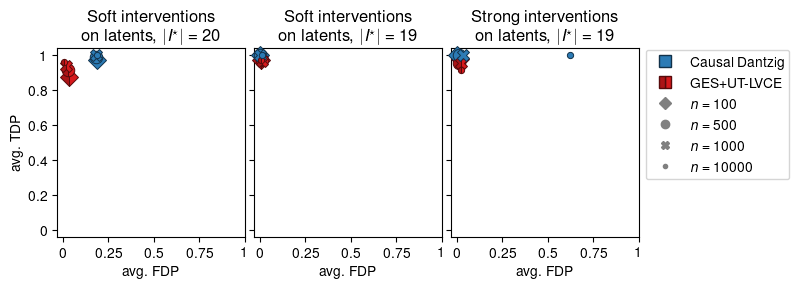

In [16]:
w = 2.5
xticks = [0, 0.25, 0.5, 0.75, 1]#, 1]#[0, 0.1, 0.2, 0.3]
xlim = [-0.03,1]#[-0.02, 0.78]
plt.figure(figsize=(3*w,w), dpi=100)
gs = gridspec.GridSpec(1, 3, wspace=0.05, hspace=0)

# Plot 1: I = 20, soft interventions
I = 20
plt.subplot(gs[0])
ax = plt.gca()
plot_roc_I(ax, values_parents_ss[I], label_y=True, xticks=xticks,legend=None)
ax.set_title("Soft interventions\non latents, $|I^\star|=%d$" % I)
ax.set_xlim(xlim)

# Plot 1: I = 19, soft interventions
I = 19
plt.subplot(gs[1])
ax = plt.gca()
plot_roc_I(ax, values_parents_ss[I], label_y=False, xticks=xticks,legend=None)
ax.set_title("Soft interventions\non latents, $|I^\star|=%d$" % I)
ax.set_xlim(xlim)

# Plot 3: I = 19, strong interventions
I = 19
plt.subplot(gs[2])
ax = plt.gca()
plot_roc_I(ax, values_parents_sh[I], label_y=False, xticks=xticks,legend=((1,1.03),1)) # ((1, 0.6),1))
ax.set_title("Strong interventions\non latents, $|I^\star|=%d$" % I)
ax.set_xlim(xlim)

filename = "figure_dantzig_assumptions.pdf"
if filename is not None:
    plt.savefig("figures/%s" % filename, bbox_inches='tight')

## Figure 7: Robustness to different intervention strengths

In [ ]:
files_hh = [[
"comparison_experiments/results_1690219970__cluster:1_seed:42_tag:fffchh_disc:15_runs:10_m:ubil_min_parents:2_G:50_k:2.1_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:1.0_i_psi_hi:5.0_h:2_e:5_size_I:10_it:0_sl:0_n:1000/compiled_results.pickle",
"comparison_experiments/results_1690219978__cluster:1_seed:42_tag:fffchh_disc:15_runs:10_m:ubil_min_parents:2_G:50_k:2.1_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:1.0_i_psi_hi:5.0_h:2_e:5_size_I:10_it:0_sl:0_n:100/compiled_results.pickle",
"comparison_experiments/results_1690220090__cluster:1_seed:42_tag:fffchh_disc:15_runs:10_m:ubil_min_parents:2_G:50_k:2.1_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:1.0_i_psi_hi:5.0_h:2_e:5_size_I:10_it:0_sl:0_n:500/compiled_results.pickle",
]]

files_hs = [[
"comparison_experiments/results_1690220084__cluster:1_seed:42_tag:fffchs_disc:15_runs:10_m:ubil_min_parents:2_G:50_k:2.1_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:2_e:5_size_I:10_it:0_sl:0_n:1000/compiled_results.pickle",
"comparison_experiments/results_1690220088__cluster:1_seed:42_tag:fffchs_disc:15_runs:10_m:ubil_min_parents:2_G:50_k:2.1_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:2_e:5_size_I:10_it:0_sl:0_n:500/compiled_results.pickle",
"comparison_experiments/results_1690220093__cluster:1_seed:42_tag:fffchs_disc:15_runs:10_m:ubil_min_parents:2_G:50_k:2.1_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:2_e:5_size_I:10_it:0_sl:0_n:100/compiled_results.pickle",
]]

files_sh = [[
"comparison_experiments/results_1690220100__cluster:1_seed:42_tag:fffcsh_disc:15_runs:10_m:ubil_min_parents:2_G:50_k:2.1_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:3.0_i_v_hi:6.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:1.0_i_psi_hi:5.0_h:2_e:5_size_I:10_it:0_sl:0_n:500/compiled_results.pickle",
"comparison_experiments/results_1690220107__cluster:1_seed:42_tag:fffcsh_disc:15_runs:10_m:ubil_min_parents:2_G:50_k:2.1_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:3.0_i_v_hi:6.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:1.0_i_psi_hi:5.0_h:2_e:5_size_I:10_it:0_sl:0_n:100/compiled_results.pickle",
"comparison_experiments/results_1690220111__cluster:1_seed:42_tag:fffcsh_disc:15_runs:10_m:ubil_min_parents:2_G:50_k:2.1_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:3.0_i_v_hi:6.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:1.0_i_psi_hi:5.0_h:2_e:5_size_I:10_it:0_sl:0_n:1000/compiled_results.pickle",
]]

files_ss = [[
"comparison_experiments/results_1690223207__cluster:1_seed:42_tag:fffcss_disc:15_runs:10_m:ubil_min_parents:2_G:50_k:2.1_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:3.0_i_v_hi:6.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:2_e:5_size_I:10_it:0_sl:0_n:100/compiled_results.pickle",
"comparison_experiments/results_1690223273__cluster:1_seed:42_tag:fffcss_disc:15_runs:10_m:ubil_min_parents:2_G:50_k:2.1_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:3.0_i_v_hi:6.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:2_e:5_size_I:10_it:0_sl:0_n:500/compiled_results.pickle",
"comparison_experiments/results_1690223787__cluster:1_seed:42_tag:fffcss_disc:15_runs:10_m:ubil_min_parents:2_G:50_k:2.1_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:3.0_i_v_hi:6.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:2_e:5_size_I:10_it:0_sl:0_n:1000/compiled_results.pickle",
]]

In [18]:
exclude = ['backShift'] # ['LRPS+GES', 'backShift']

In [19]:
values_ss, _, _ = process_results(files_ss, debug=False, what='graphs', exclude=exclude)

In [20]:
values_sh, _, _ = process_results(files_sh, debug=False, what='graphs', exclude=exclude)

In [21]:
values_hs, _, _ = process_results(files_hs, debug=False, what='graphs', exclude=exclude)

In [22]:
values_hh, _, _ = process_results(files_hh, debug=False, what='graphs', exclude=exclude)

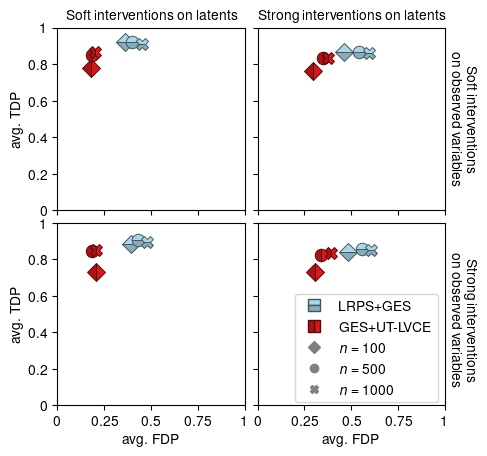

In [23]:
w = 2.5
xticks = [0, 0.25, 0.5, 0.75, 1]#[0, 0.1, 0.2, 0.3]
plt.figure(figsize=(2*w,2*w), dpi=100)
gs = gridspec.GridSpec(2, 2, wspace=0.07, hspace=0.07)

I = 10
s = 10

# Plot
plt.subplot(gs[0,0])
ax = plt.gca()
plot_roc_I(ax, values_ss[I], label_y=True, xticks=xticks,legend=None)
ax.set_title("Soft interventions on latents", size=s)
ax.set_xticklabels([])
ax.set_ylim([0,1])

# Plot
plt.subplot(gs[1,0])
ax = plt.gca()
plot_roc_I(ax, values_hs[I], label_y=True, xticks=xticks,legend=None)
ax.set_ylim([0,1])

# Plot
plt.subplot(gs[0,1])
ax = plt.gca()
plot_roc_I(ax, values_sh[I], label_y=False, xticks=xticks,legend=None)
ax.set_title("Strong interventions on latents", size=s)
ax.text(1.1,0.5,"Soft interventions\non observed variables", ha='center', va='center', rotation=270, size=s)
ax.text(1.1,-0.6,"Strong interventions\non observed variables", ha='center', va='center', rotation=270, size=s)
ax.set_xticklabels([])
ax.set_ylim([0,1])

# Plot
plt.subplot(gs[1,1])
ax = plt.gca()
plot_roc_I(ax, values_hh[I], label_y=False, xticks=xticks,legend=((1,0.65),1))
ax.set_title("", size=s)
ax.set_ylim([0,1])

filename = "figure_robustness.pdf"
if filename is not None:
    plt.savefig("figures/%s" % filename, bbox_inches='tight')

## Figure 8: Effect of GES estimate not being a supergraph of the true I-MEC

In [24]:
files_hs = [
[
"comparison_experiments/results_1690220084__cluster:1_seed:42_tag:fffchs_disc:15_runs:10_m:ubil_min_parents:2_G:50_k:2.1_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:2_e:5_size_I:10_it:0_sl:0_n:1000/compiled_results.pickle",
"comparison_experiments/results_1690220088__cluster:1_seed:42_tag:fffchs_disc:15_runs:10_m:ubil_min_parents:2_G:50_k:2.1_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:2_e:5_size_I:10_it:0_sl:0_n:500/compiled_results.pickle",
"comparison_experiments/results_1690220093__cluster:1_seed:42_tag:fffchs_disc:15_runs:10_m:ubil_min_parents:2_G:50_k:2.1_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:2_e:5_size_I:10_it:0_sl:0_n:100/compiled_results.pickle",
],
[
"comparison_experiments/results_1690220114__cluster:1_seed:42_tag:fffchs_disc:15_runs:10_m:ubil_min_parents:2_G:50_k:2.1_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:2_e:5_size_I:20_it:1_sl:0_n:500/compiled_results.pickle",
"comparison_experiments/results_1690220117__cluster:1_seed:42_tag:fffchs_disc:15_runs:10_m:ubil_min_parents:2_G:50_k:2.1_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:2_e:5_size_I:20_it:1_sl:0_n:100/compiled_results.pickle",
"comparison_experiments/results_1690220118__cluster:1_seed:42_tag:fffchs_disc:15_runs:10_m:ubil_min_parents:2_G:50_k:2.1_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:2_e:5_size_I:20_it:1_sl:0_n:1000/compiled_results.pickle",
]]

In [25]:
def plot_roc_bin(ax,values_yes,values_no,mean=True,label_y=False,xticks=None,legend=None):
    # Parameters
    marker_opts =  [{'fillstyle': 'right', 'markerfacecolor': colors[0], 'markerfacecoloralt': colorsa[0], 'markeredgecolor': colorsb[0]},
                    {'fillstyle': 'top', 'markerfacecolor': colors[2], 'markerfacecoloralt': colorsa[2], 'markeredgecolor': colorsb[2]}]
    markers_n = dict(zip([100,500,1000,10000], ['D', 'o', 'X', '.']))
    yticks = [0, 0.2, 0.4, 0.6, 0.8, 1]
    # Plot
    for i,values in enumerate([values_yes, values_no]):
        used_ns, used_methods = set(), set()   
        for n, dict_n in values.items():
            used_ns.add(n)
            for name, (t1,t2) in dict_n.items():
                used_methods.add(name)
                x, y = (t1.mean(),1-t2.mean()) if mean else (t1, 1-t2)
                ax.plot(x, y,
                        marker=markers_n[n],
                        markersize=9,
                        zorder=10 + n,
                        clip_on=False,
                        markeredgewidth=0.7,
                        **marker_opts[i])
    # Compose legend
    if legend is not None:
        used_ns = sorted(used_ns)

        # Methods
        method_entries = [Line2D([0], [0],                                 
                                 linestyle='None',
                                 marker='s',
                                 markersize=8,
                                 **marker_opts[j]) for j in [0,1]]
        method_strings = ["Yes", "No"]
        # n
        sample_size_entries = [Line2D([0], [0], linestyle='None', color='gray', marker=markers_n[n]) for n in used_ns]
        sample_size_strings = ["$n = %d$" % n for n in used_ns]
        # Putting it all together
        entries = method_entries + sample_size_entries
        strings = method_strings + sample_size_strings
        pos, ncol = legend
        ax.legend(entries, strings, bbox_to_anchor=pos, ncol=ncol, title="GES output\ncontains\nsupergraph", prop = {'size': 8}, title_fontsize=10)
    
    # Other formatting
    #ax.set_ylim(lim)
    #ax.set_xlim(lim)
    ax.set_xlabel("avg. FDP")
    if xticks is not None:
        ax.set_xticks(xticks)
        ax.set_xticklabels(xticks)
    ax.set_yticks(yticks)
    ax.set_yticklabels([])
    ax.set_ylim([-0.04, 1.04])
    if label_y:        
        ax.set_yticklabels(yticks)
        ax.set_ylabel("avg. TDP")        

In [26]:
values_hs, supergraphs_hs, size_initial_graphs_hs = process_results(files_hs, debug=False, what='graphs', exclude=exclude)

**Partition results into cases where GES output contained at least one supergraph of an I-MEC representative**

In [27]:
values_hs_yes = {}
values_hs_no = {}
for size_I,dict_I in values_hs.items():
    #print(size_I)
    yes_dict_I, no_dict_I = {}, {}
    for n, dict_n in dict_I.items():
        #print(" ", n)
        (t1,t2) = dict_n['UT-LVCE']
        yes_mask = supergraphs_hs[size_I][n] > 0
        no_mask = supergraphs_hs[size_I][n] == 0
        yes_dict_I[n] = {'UT-LVCE': (t1[yes_mask], t2[yes_mask])}
        no_dict_I[n] = {'UT-LVCE': (t1[no_mask], t2[no_mask])}
    values_hs_yes[size_I] = yes_dict_I
    values_hs_no[size_I] = no_dict_I

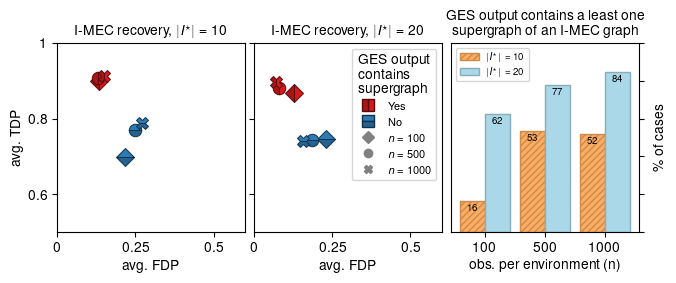

In [28]:
w = 2.5
xticks = [0, 0.25, 0.5, 0.75, 1]#[0, 0.1, 0.2, 0.3]
plt.figure(figsize=(3*w,w), dpi=100)
gs = gridspec.GridSpec(1, 3, wspace=0.05, hspace=0)

xlim = [0, 0.6]
# Plot 1: I = 10
I = 10
plt.subplot(gs[0])
ax = plt.gca()
plot_roc_bin(ax, values_hs_yes[I], values_hs_no[I], label_y=True, xticks=xticks,legend=None)#((-0.25,1),1))
ax.set_title("I-MEC recovery, $|I^\star|=%d$" % I, size=10)
ax.set_xlim(xlim)
ax.set_ylim(0.5, 1)

# Plot 1: I = 20
I = 20
plt.subplot(gs[1])
ax = plt.gca()
plot_roc_bin(ax, values_hs_yes[I], values_hs_no[I], label_y=False, xticks=xticks,legend=((1,1),1))#None)
ax.set_title("I-MEC recovery, $|I^\star|=%d$" % I, size=10)
ax.set_xlim(xlim)
ax.set_ylim(0.5, 1)


# --------------------------------------------------
# Histogram
supergraphs = supergraphs_hs
Is_to_plot = [10,20]
total_cases = 500
plt.subplot(gs[2])
ax = plt.gca()
j = 0
dev = 0.42
c = [colors[i] for i in [1,3]]
cb = [colorsa[i] for i in [1,3]]
hatch = ['/////', None] # / , \\ , | , - , + , x, o, O, ., *
for size_I, dict_I in supergraphs.items():
    if size_I not in Is_to_plot:
        continue
    ns_freq = sorted(zip(dict_I.keys(), [(counts > 0).sum() for counts in dict_I.values()]))
    Ns = [n for n,_ in ns_freq]
    freqs = np.array([f / total_cases for _,f in ns_freq]) * 100
    
    x = np.arange(len(Ns)) + dev*j
    ax.bar(x, freqs, width=dev, label="$|I^\star|=%d$" % size_I, color=c[j], edgecolor=cb[j], hatch=hatch[j])
    
    for i,freq in enumerate(freqs):        
        ax.text(i+dev*j,freq-5,("%d" % (freq)), ha='center',size=7)
    
    j += 1
ax.set_xticks(np.arange(len(Ns)) + dev / 2)
ax.set_xticklabels(Ns)
ax.set_ylim(0,100)
ax.set_title("GES output contains a least one\nsupergraph of an I-MEC graph", size=10)
ax.set_ylabel("\% of cases")
ax.set_xlabel("obs. per environment (n)")
ax.yaxis.tick_right()
ax.set_yticklabels([])
ax.yaxis.set_label_position("right")
ax.legend(ncol=1, prop={'size': 7})


filename = "figure_ges_binning.pdf"
if filename is not None:
    plt.savefig("figures/%s" % filename, bbox_inches='tight')

## Figure 11: number of latents & graph densities

In [7]:
def process_results(all_files, what='parents', debug=False, exclude=[]):
    # Iterate over intervention sizes
    values = {}
    supergraphs = {}
    size_initial = {}
    for i,files_size_I in enumerate(all_files):  
        # Iterate over sample sizes
        dict_Ns = {}
        supergraphs_Ns = {}
        size_initial_Ns = {}
        for j,file_n in enumerate(files_size_I):
            args, test_cases, results = read_result(file_n)
            # Check that intervention size is consistent
            if j == 0:
                key = (args.h, args.k)
                print("  h,k =", key) if debug else None
            if j > 0:
                print(key, (args.h, args.k))
                assert key == (args.h, args.k)
            # Iterate over methods            
            dict_methods = {}            
            print("    n =", args.n) if debug else None
            # If looking at parent estimates                        
            if what=='parents':                                
                for (name,method) in names_methods:
                    if name in exclude:
                        continue
                    print("      method =", name) if debug else None
                    t1 = np.array(results['t1_%s' % method])
                    t2 = np.array(results['t2_%s' % method])
                    # Store results for this method
                    dict_methods[name] = (t1,t2)
            # If looking at I-MEC estimates            
            elif what=='graphs':
                truth = [utils.imec(m.A, I) for m,I in test_cases]
                estimates = {}
                if 'LRPS+GES' not in exclude:
                    estimates['LRPS+GES'] = [utils.all_dags(cpdag) for cpdag in results['graphs_lrps']]
                if 'backShift' not in exclude:
                    estimates['backShift'] = [[A] for A in results['graphs_backshift']]
                if 'UT-LVCE' not in exclude:
                    estimates['UT-LVCE'] = [utils.imec(m.A,I) for (m,I,_),_ in results['ut_lvce_output']]
                    # Count instances of GES upergraphs for binning
                    all_initial_graphs = [h['initial_graphs'] for _,h in results['ut_lvce_output']]
                    counts = np.zeros(len(truth))
                    sizes = np.zeros(len(truth))
                    for j,(true_imec,initial_graphs) in enumerate(zip(truth,all_initial_graphs)):
                        sizes[j] = len(initial_graphs)
                        for A0 in initial_graphs:
                            if np.array([utils.is_supergraph(A0, A) for A in true_imec]).any():
                                 counts[j] += 1
                    supergraphs_Ns[args.n] = counts
                    size_initial_Ns[args.n] = sizes
                for name in [name for name in names if name not in exclude + ['Causal Dantzig']]:
                    print("      method =", name) if debug else None
                    t1 = np.zeros(len(truth))
                    t2 = np.zeros(len(truth))
                    for j, true_imec in enumerate(truth):
                        t1[j] = ut_lvcm.metrics.type_1_structc(estimates[name][j], true_imec)
                        t2[j] = ut_lvcm.metrics.type_2_structc(estimates[name][j], true_imec)
                    dict_methods[name] = (t1, t2)
            # Store results for this sample size
            dict_Ns[args.n] = dict_methods            
        # Store results for this intervention size
        values[key] = dict_Ns
        supergraphs[key] = supergraphs_Ns
        size_initial[key] = size_initial_Ns
    return values, supergraphs, size_initial

In [14]:
files = [
[
"comparison_experiments/results_1690549189__cluster:1_seed:42_tag:hd2l_disc:15_runs:10_m:ubil_min_parents:2_G:50_k:1.9_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:2_e:5_size_I:10_it:0_sl:0_Hs:1,2,3,4_n:100/compiled_results.pickle",
#"comparison_experiments/results_1690549598__cluster:1_seed:42_tag:hd2l_disc:15_runs:10_m:ubil_min_parents:2_G:50_k:1.9_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:2_e:5_size_I:10_it:0_sl:0_Hs:1,2,3,4_n:500/compiled_results.pickle",
#"comparison_experiments/results_1690549661__cluster:1_seed:42_tag:hd2l_disc:15_runs:10_m:ubil_min_parents:2_G:50_k:1.9_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:2_e:5_size_I:10_it:0_sl:0_Hs:1,2,3,4_n:1000/compiled_results.pickle",
],[
#"comparison_experiments/results_1690549724__cluster:1_seed:42_tag:hd2m_disc:15_runs:10_m:ubil_min_parents:2_G:50_k:2.1_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:2_e:5_size_I:10_it:0_sl:0_Hs:1,2,3,4_n:500/compiled_results.pickle",
"comparison_experiments/results_1690549735__cluster:1_seed:42_tag:hd2m_disc:15_runs:10_m:ubil_min_parents:2_G:50_k:2.1_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:2_e:5_size_I:10_it:0_sl:0_Hs:1,2,3,4_n:100/compiled_results.pickle",
#"comparison_experiments/results_1690549746__cluster:1_seed:42_tag:hd2m_disc:15_runs:10_m:ubil_min_parents:2_G:50_k:2.1_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:2_e:5_size_I:10_it:0_sl:0_Hs:1,2,3,4_n:1000/compiled_results.pickle",
],[
"comparison_experiments/results_1690549821__cluster:1_seed:42_tag:hd2h_disc:15_runs:10_m:ubil_min_parents:2_G:50_k:2.3_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:2_e:5_size_I:10_it:0_sl:0_Hs:1,2,3,4_n:1000/compiled_results.pickle",
#"comparison_experiments/results_1690549864__cluster:1_seed:42_tag:hd2h_disc:15_runs:10_m:ubil_min_parents:2_G:50_k:2.3_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:2_e:5_size_I:10_it:0_sl:0_Hs:1,2,3,4_n:100/compiled_results.pickle",
#"comparison_experiments/results_1690549910__cluster:1_seed:42_tag:hd2h_disc:15_runs:10_m:ubil_min_parents:2_G:50_k:2.3_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:2_e:5_size_I:10_it:0_sl:0_Hs:1,2,3,4_n:500/compiled_results.pickle",
],[
"comparison_experiments/results_1690549613__cluster:1_seed:42_tag:hd3l_disc:15_runs:10_m:ubil_min_parents:2_G:50_k:1.9_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:3_e:5_size_I:10_it:0_sl:0_Hs:1,2,3,4_n:100/compiled_results.pickle",
#"comparison_experiments/results_1690549682__cluster:1_seed:42_tag:hd3l_disc:15_runs:10_m:ubil_min_parents:2_G:50_k:1.9_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:3_e:5_size_I:10_it:0_sl:0_Hs:1,2,3,4_n:1000/compiled_results.pickle",
#"comparison_experiments/results_1690549685__cluster:1_seed:42_tag:hd3l_disc:15_runs:10_m:ubil_min_parents:2_G:50_k:1.9_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:3_e:5_size_I:10_it:0_sl:0_Hs:1,2,3,4_n:500/compiled_results.pickle",
],[    
"comparison_experiments/results_1690549840__cluster:1_seed:42_tag:hd3m_disc:15_runs:10_m:ubil_min_parents:2_G:50_k:2.1_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:3_e:5_size_I:10_it:0_sl:0_Hs:1,2,3,4_n:100/compiled_results.pickle",
#"comparison_experiments/results_1690549840__cluster:1_seed:42_tag:hd3m_disc:15_runs:10_m:ubil_min_parents:2_G:50_k:2.1_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:3_e:5_size_I:10_it:0_sl:0_Hs:1,2,3,4_n:1000/compiled_results.pickle",
#"comparison_experiments/results_1690549846__cluster:1_seed:42_tag:hd3m_disc:15_runs:10_m:ubil_min_parents:2_G:50_k:2.1_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:3_e:5_size_I:10_it:0_sl:0_Hs:1,2,3,4_n:500/compiled_results.pickle",
],[ 
#"comparison_experiments/results_1690549978__cluster:1_seed:42_tag:hd3h_disc:15_runs:10_m:ubil_min_parents:2_G:50_k:2.3_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:3_e:5_size_I:10_it:0_sl:0_Hs:1,2,3,4_n:1000/compiled_results.pickle",
"comparison_experiments/results_1690549982__cluster:1_seed:42_tag:hd3h_disc:15_runs:10_m:ubil_min_parents:2_G:50_k:2.3_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:3_e:5_size_I:10_it:0_sl:0_Hs:1,2,3,4_n:100/compiled_results.pickle",
#"comparison_experiments/results_1690550003__cluster:1_seed:42_tag:hd3h_disc:15_runs:10_m:ubil_min_parents:2_G:50_k:2.3_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:3_e:5_size_I:10_it:0_sl:0_Hs:1,2,3,4_n:500/compiled_results.pickle",
],[
#"comparison_experiments/results_1690549666__cluster:1_seed:42_tag:hd4l_disc:15_runs:10_m:ubil_min_parents:2_G:50_k:1.9_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:4_e:5_size_I:10_it:0_sl:0_Hs:1,2,3,4_n:1000/compiled_results.pickle",
#"comparison_experiments/results_1690549667__cluster:1_seed:42_tag:hd4l_disc:15_runs:10_m:ubil_min_parents:2_G:50_k:1.9_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:4_e:5_size_I:10_it:0_sl:0_Hs:1,2,3,4_n:500/compiled_results.pickle",
"comparison_experiments/results_1690549681__cluster:1_seed:42_tag:hd4l_disc:15_runs:10_m:ubil_min_parents:2_G:50_k:1.9_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:4_e:5_size_I:10_it:0_sl:0_Hs:1,2,3,4_n:100/compiled_results.pickle",
],[
"comparison_experiments/results_1690549810__cluster:1_seed:42_tag:hd4m_disc:15_runs:10_m:ubil_min_parents:2_G:50_k:2.1_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:4_e:5_size_I:10_it:0_sl:0_Hs:1,2,3,4_n:100/compiled_results.pickle",
#"comparison_experiments/results_1690549813__cluster:1_seed:42_tag:hd4m_disc:15_runs:10_m:ubil_min_parents:2_G:50_k:2.1_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:4_e:5_size_I:10_it:0_sl:0_Hs:1,2,3,4_n:1000/compiled_results.pickle",
#"comparison_experiments/results_1690549852__cluster:1_seed:42_tag:hd4m_disc:15_runs:10_m:ubil_min_parents:2_G:50_k:2.1_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:4_e:5_size_I:10_it:0_sl:0_Hs:1,2,3,4_n:500/compiled_results.pickle",
],[
"comparison_experiments/results_1690549991__cluster:1_seed:42_tag:hd4h_disc:15_runs:10_m:ubil_min_parents:2_G:50_k:2.3_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:4_e:5_size_I:10_it:0_sl:0_Hs:1,2,3,4_n:100/compiled_results.pickle",
#"comparison_experiments/results_1690550093__cluster:1_seed:42_tag:hd4h_disc:15_runs:10_m:ubil_min_parents:2_G:50_k:2.3_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:4_e:5_size_I:10_it:0_sl:0_Hs:1,2,3,4_n:500/compiled_results.pickle",
#"comparison_experiments/results_1690551063__cluster:1_seed:42_tag:hd4h_disc:15_runs:10_m:ubil_min_parents:2_G:50_k:2.3_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:4_e:5_size_I:10_it:0_sl:0_Hs:1,2,3,4_n:1000/compiled_results.pickle",
]]

In [8]:
files = [
[
"comparison_experiments/results_1690549189__cluster:1_seed:42_tag:hd2l_disc:15_runs:10_m:ubil_min_parents:2_G:50_k:1.9_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:2_e:5_size_I:10_it:0_sl:0_Hs:1,2,3,4_n:100/compiled_results.pickle",
"comparison_experiments/results_1690549598__cluster:1_seed:42_tag:hd2l_disc:15_runs:10_m:ubil_min_parents:2_G:50_k:1.9_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:2_e:5_size_I:10_it:0_sl:0_Hs:1,2,3,4_n:500/compiled_results.pickle",
"comparison_experiments/results_1690549661__cluster:1_seed:42_tag:hd2l_disc:15_runs:10_m:ubil_min_parents:2_G:50_k:1.9_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:2_e:5_size_I:10_it:0_sl:0_Hs:1,2,3,4_n:1000/compiled_results.pickle",
],[
"comparison_experiments/results_1692094642__cluster:1_seed:42_tag:hd2m_disc:15_runs:10_m:ubil_min_parents:2_G:50_k:2.5_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:2_e:5_size_I:10_it:0_sl:0_Hs:1,2,3,4_n:100/compiled_results.pickle",
"comparison_experiments/results_1692094647__cluster:1_seed:42_tag:hd2m_disc:15_runs:10_m:ubil_min_parents:2_G:50_k:2.5_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:2_e:5_size_I:10_it:0_sl:0_Hs:1,2,3,4_n:500/compiled_results.pickle",
"comparison_experiments/results_1692094591__cluster:1_seed:42_tag:hd2m_disc:15_runs:10_m:ubil_min_parents:2_G:50_k:2.5_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:2_e:5_size_I:10_it:0_sl:0_Hs:1,2,3,4_n:1000/compiled_results.pickle",
],[
"comparison_experiments/results_1692099716__cluster:1_seed:42_tag:hd2h_disc:15_runs:10_m:ubil_min_parents:2_G:50_k:3.0_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:2_e:5_size_I:10_it:0_sl:0_Hs:1,2,3,4_n:100/compiled_results.pickle",
"comparison_experiments/results_1692100187__cluster:1_seed:42_tag:hd2h_disc:15_runs:10_m:ubil_min_parents:2_G:50_k:3.0_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:2_e:5_size_I:10_it:0_sl:0_Hs:1,2,3,4_n:500/compiled_results.pickle",
"comparison_experiments/results_1692099746__cluster:1_seed:42_tag:hd2h_disc:15_runs:10_m:ubil_min_parents:2_G:50_k:3.0_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:2_e:5_size_I:10_it:0_sl:0_Hs:1,2,3,4_n:1000/compiled_results.pickle",
],[
"comparison_experiments/results_1690549613__cluster:1_seed:42_tag:hd3l_disc:15_runs:10_m:ubil_min_parents:2_G:50_k:1.9_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:3_e:5_size_I:10_it:0_sl:0_Hs:1,2,3,4_n:100/compiled_results.pickle",
"comparison_experiments/results_1690549682__cluster:1_seed:42_tag:hd3l_disc:15_runs:10_m:ubil_min_parents:2_G:50_k:1.9_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:3_e:5_size_I:10_it:0_sl:0_Hs:1,2,3,4_n:1000/compiled_results.pickle",
"comparison_experiments/results_1690549685__cluster:1_seed:42_tag:hd3l_disc:15_runs:10_m:ubil_min_parents:2_G:50_k:1.9_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:3_e:5_size_I:10_it:0_sl:0_Hs:1,2,3,4_n:500/compiled_results.pickle",
],[    
"comparison_experiments/results_1692094654__cluster:1_seed:42_tag:hd3m_disc:15_runs:10_m:ubil_min_parents:2_G:50_k:2.5_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:3_e:5_size_I:10_it:0_sl:0_Hs:1,2,3,4_n:100/compiled_results.pickle",
"comparison_experiments/results_1692094623__cluster:1_seed:42_tag:hd3m_disc:15_runs:10_m:ubil_min_parents:2_G:50_k:2.5_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:3_e:5_size_I:10_it:0_sl:0_Hs:1,2,3,4_n:500/compiled_results.pickle",
"comparison_experiments/results_1692094610__cluster:1_seed:42_tag:hd3m_disc:15_runs:10_m:ubil_min_parents:2_G:50_k:2.5_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:3_e:5_size_I:10_it:0_sl:0_Hs:1,2,3,4_n:1000/compiled_results.pickle",
],[ 
"comparison_experiments/results_1692100221__cluster:1_seed:42_tag:hd3h_disc:15_runs:10_m:ubil_min_parents:2_G:50_k:3.0_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:3_e:5_size_I:10_it:0_sl:0_Hs:1,2,3,4_n:100/compiled_results.pickle",
"comparison_experiments/results_1692099727__cluster:1_seed:42_tag:hd3h_disc:15_runs:10_m:ubil_min_parents:2_G:50_k:3.0_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:3_e:5_size_I:10_it:0_sl:0_Hs:1,2,3,4_n:500/compiled_results.pickle",
"comparison_experiments/results_1692100710__cluster:1_seed:42_tag:hd3h_disc:15_runs:10_m:ubil_min_parents:2_G:50_k:3.0_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:3_e:5_size_I:10_it:0_sl:0_Hs:1,2,3,4_n:1000/compiled_results.pickle",
],[
"comparison_experiments/results_1690549666__cluster:1_seed:42_tag:hd4l_disc:15_runs:10_m:ubil_min_parents:2_G:50_k:1.9_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:4_e:5_size_I:10_it:0_sl:0_Hs:1,2,3,4_n:1000/compiled_results.pickle",
"comparison_experiments/results_1690549667__cluster:1_seed:42_tag:hd4l_disc:15_runs:10_m:ubil_min_parents:2_G:50_k:1.9_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:4_e:5_size_I:10_it:0_sl:0_Hs:1,2,3,4_n:500/compiled_results.pickle",
"comparison_experiments/results_1690549681__cluster:1_seed:42_tag:hd4l_disc:15_runs:10_m:ubil_min_parents:2_G:50_k:1.9_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:4_e:5_size_I:10_it:0_sl:0_Hs:1,2,3,4_n:100/compiled_results.pickle",
],[
"comparison_experiments/results_1692094819__cluster:1_seed:42_tag:hd4m_disc:15_runs:10_m:ubil_min_parents:2_G:50_k:2.5_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:4_e:5_size_I:10_it:0_sl:0_Hs:1,2,3,4_n:100/compiled_results.pickle",
"comparison_experiments/results_1692095039__cluster:1_seed:42_tag:hd4m_disc:15_runs:10_m:ubil_min_parents:2_G:50_k:2.5_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:4_e:5_size_I:10_it:0_sl:0_Hs:1,2,3,4_n:500/compiled_results.pickle",
"comparison_experiments/results_1692095445__cluster:1_seed:42_tag:hd4m_disc:15_runs:10_m:ubil_min_parents:2_G:50_k:2.5_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:4_e:5_size_I:10_it:0_sl:0_Hs:1,2,3,4_n:1000/compiled_results.pickle",
],[
"comparison_experiments/results_1692101002__cluster:1_seed:42_tag:hd4h_disc:15_runs:10_m:ubil_min_parents:2_G:50_k:3.0_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:4_e:5_size_I:10_it:0_sl:0_Hs:1,2,3,4_n:100/compiled_results.pickle",
"comparison_experiments/results_1692103557__cluster:1_seed:42_tag:hd4h_disc:15_runs:10_m:ubil_min_parents:2_G:50_k:3.0_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:4_e:5_size_I:10_it:0_sl:0_Hs:1,2,3,4_n:500/compiled_results.pickle",
"comparison_experiments/results_1692103545__cluster:1_seed:42_tag:hd4h_disc:15_runs:10_m:ubil_min_parents:2_G:50_k:3.0_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:4_e:5_size_I:10_it:0_sl:0_Hs:1,2,3,4_n:1000/compiled_results.pickle",
]]

In [16]:
######################################################################
# h = 2
files = [
[
"comparison_experiments/results_1693367311__cluster:1_seed:42_tag:z_disc:15_runs:10_m:ubil_pa:2_G:50_k:1.9_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:2_e:5_size_I:10_it:0_sl:0_umd:0_Hs:1,2,3,4,5_n:100/compiled_results.pickle",
"comparison_experiments/results_1693371904__cluster:1_seed:42_tag:z_disc:15_runs:10_m:ubil_pa:2_G:50_k:1.9_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:2_e:5_size_I:10_it:0_sl:0_umd:0_Hs:1,2,3,4,5_n:1000/compiled_results.pickle",
"comparison_experiments/results_1693367758__cluster:1_seed:42_tag:z_disc:15_runs:10_m:ubil_pa:2_G:50_k:1.9_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:2_e:5_size_I:10_it:0_sl:0_umd:0_Hs:1,2,3,4,5_n:500/compiled_results.pickle",
],[
"comparison_experiments/results_1693379636__cluster:1_seed:42_tag:z_disc:15_runs:10_m:ubil_pa:2_G:50_k:2.5_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:2_e:5_size_I:10_it:0_sl:0_umd:0_Hs:1,2,3,4,5_n:100/compiled_results.pickle",
"comparison_experiments/results_1693379619__cluster:1_seed:42_tag:z_disc:15_runs:10_m:ubil_pa:2_G:50_k:2.5_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:2_e:5_size_I:10_it:0_sl:0_umd:0_Hs:1,2,3,4,5_n:1000/compiled_results.pickle",
],[
"comparison_experiments/results_1693379614__cluster:1_seed:42_tag:z_disc:15_runs:10_m:ubil_pa:2_G:50_k:3.0_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:2_e:5_size_I:10_it:0_sl:0_umd:0_Hs:1,2,3,4,5_n:100/compiled_results.pickle",
"comparison_experiments/results_1693379557__cluster:1_seed:42_tag:z_disc:15_runs:10_m:ubil_pa:2_G:50_k:3.0_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:2_e:5_size_I:10_it:0_sl:0_umd:0_Hs:1,2,3,4,5_n:1000/compiled_results.pickle",
"comparison_experiments/results_1693379599__cluster:1_seed:42_tag:z_disc:15_runs:10_m:ubil_pa:2_G:50_k:3.0_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:2_e:5_size_I:10_it:0_sl:0_umd:0_Hs:1,2,3,4,5_n:500/compiled_results.pickle",
],[
######################################################################
# h = 3
"comparison_experiments/results_1693379227__cluster:1_seed:42_tag:z_disc:15_runs:10_m:ubil_pa:2_G:50_k:1.9_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:3_e:5_size_I:10_it:0_sl:0_umd:0_Hs:1,2,3,4,5_n:1000/compiled_results.pickle",
"comparison_experiments/results_1693379222__cluster:1_seed:42_tag:z_disc:15_runs:10_m:ubil_pa:2_G:50_k:1.9_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:3_e:5_size_I:10_it:0_sl:0_umd:0_Hs:1,2,3,4,5_n:500/compiled_results.pickle",
],[
"comparison_experiments/results_1693379618__cluster:1_seed:42_tag:z_disc:15_runs:10_m:ubil_pa:2_G:50_k:2.5_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:3_e:5_size_I:10_it:0_sl:0_umd:0_Hs:1,2,3,4,5_n:100/compiled_results.pickle",
"comparison_experiments/results_1693379751__cluster:1_seed:42_tag:z_disc:15_runs:10_m:ubil_pa:2_G:50_k:2.5_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:3_e:5_size_I:10_it:0_sl:0_umd:0_Hs:1,2,3,4,5_n:1000/compiled_results.pickle",
"comparison_experiments/results_1693379714__cluster:1_seed:42_tag:z_disc:15_runs:10_m:ubil_pa:2_G:50_k:2.5_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:3_e:5_size_I:10_it:0_sl:0_umd:0_Hs:1,2,3,4,5_n:500/compiled_results.pickle",
],[
"comparison_experiments/results_1693379662__cluster:1_seed:42_tag:z_disc:15_runs:10_m:ubil_pa:2_G:50_k:3.0_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:3_e:5_size_I:10_it:0_sl:0_umd:0_Hs:1,2,3,4,5_n:100/compiled_results.pickle",
"comparison_experiments/results_1693379561__cluster:1_seed:42_tag:z_disc:15_runs:10_m:ubil_pa:2_G:50_k:3.0_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:3_e:5_size_I:10_it:0_sl:0_umd:0_Hs:1,2,3,4,5_n:500/compiled_results.pickle",
],[
######################################################################
# h = 4
"comparison_experiments/results_1693379228__cluster:1_seed:42_tag:z_disc:15_runs:10_m:ubil_pa:2_G:50_k:1.9_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:4_e:5_size_I:10_it:0_sl:0_umd:0_Hs:1,2,3,4,5_n:100/compiled_results.pickle",
"comparison_experiments/results_1693379231__cluster:1_seed:42_tag:z_disc:15_runs:10_m:ubil_pa:2_G:50_k:1.9_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:4_e:5_size_I:10_it:0_sl:0_umd:0_Hs:1,2,3,4,5_n:1000/compiled_results.pickle",
"comparison_experiments/results_1693379223__cluster:1_seed:42_tag:z_disc:15_runs:10_m:ubil_pa:2_G:50_k:1.9_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:4_e:5_size_I:10_it:0_sl:0_umd:0_Hs:1,2,3,4,5_n:500/compiled_results.pickle",
],[
"comparison_experiments/results_1693379676__cluster:1_seed:42_tag:z_disc:15_runs:10_m:ubil_pa:2_G:50_k:2.5_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:4_e:5_size_I:10_it:0_sl:0_umd:0_Hs:1,2,3,4,5_n:100/compiled_results.pickle",
"comparison_experiments/results_1693379668__cluster:1_seed:42_tag:z_disc:15_runs:10_m:ubil_pa:2_G:50_k:2.5_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:4_e:5_size_I:10_it:0_sl:0_umd:0_Hs:1,2,3,4,5_n:1000/compiled_results.pickle",
"comparison_experiments/results_1693379632__cluster:1_seed:42_tag:z_disc:15_runs:10_m:ubil_pa:2_G:50_k:2.5_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:4_e:5_size_I:10_it:0_sl:0_umd:0_Hs:1,2,3,4,5_n:500/compiled_results.pickle",
],[
"comparison_experiments/results_1693379578__cluster:1_seed:42_tag:z_disc:15_runs:10_m:ubil_pa:2_G:50_k:3.0_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:4_e:5_size_I:10_it:0_sl:0_umd:0_Hs:1,2,3,4,5_n:100/compiled_results.pickle",
"comparison_experiments/results_1693379658__cluster:1_seed:42_tag:z_disc:15_runs:10_m:ubil_pa:2_G:50_k:3.0_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:4_e:5_size_I:10_it:0_sl:0_umd:0_Hs:1,2,3,4,5_n:1000/compiled_results.pickle",
"comparison_experiments/results_1693379721__cluster:1_seed:42_tag:z_disc:15_runs:10_m:ubil_pa:2_G:50_k:3.0_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:4_e:5_size_I:10_it:0_sl:0_umd:0_Hs:1,2,3,4,5_n:500/compiled_results.pickle",
],[
######################################################################
# h = 5
"comparison_experiments/results_1693379256__cluster:1_seed:42_tag:z_disc:15_runs:10_m:ubil_pa:2_G:50_k:1.9_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:5_e:5_size_I:10_it:0_sl:0_umd:0_Hs:1,2,3,4,5_n:100/compiled_results.pickle",
"comparison_experiments/results_1693379259__cluster:1_seed:42_tag:z_disc:15_runs:10_m:ubil_pa:2_G:50_k:1.9_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:5_e:5_size_I:10_it:0_sl:0_umd:0_Hs:1,2,3,4,5_n:1000/compiled_results.pickle",
"comparison_experiments/results_1693379241__cluster:1_seed:42_tag:z_disc:15_runs:10_m:ubil_pa:2_G:50_k:1.9_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:5_e:5_size_I:10_it:0_sl:0_umd:0_Hs:1,2,3,4,5_n:500/compiled_results.pickle",
],[
"comparison_experiments/results_1693379631__cluster:1_seed:42_tag:z_disc:15_runs:10_m:ubil_pa:2_G:50_k:2.5_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:5_e:5_size_I:10_it:0_sl:0_umd:0_Hs:1,2,3,4,5_n:100/compiled_results.pickle",
"comparison_experiments/results_1693379670__cluster:1_seed:42_tag:z_disc:15_runs:10_m:ubil_pa:2_G:50_k:2.5_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:5_e:5_size_I:10_it:0_sl:0_umd:0_Hs:1,2,3,4,5_n:1000/compiled_results.pickle",
"comparison_experiments/results_1693379623__cluster:1_seed:42_tag:z_disc:15_runs:10_m:ubil_pa:2_G:50_k:2.5_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:5_e:5_size_I:10_it:0_sl:0_umd:0_Hs:1,2,3,4,5_n:500/compiled_results.pickle",
],[
"comparison_experiments/results_1693379562__cluster:1_seed:42_tag:z_disc:15_runs:10_m:ubil_pa:2_G:50_k:3.0_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:5_e:5_size_I:10_it:0_sl:0_umd:0_Hs:1,2,3,4,5_n:100/compiled_results.pickle",
"comparison_experiments/results_1693379640__cluster:1_seed:42_tag:z_disc:15_runs:10_m:ubil_pa:2_G:50_k:3.0_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:5_e:5_size_I:10_it:0_sl:0_umd:0_Hs:1,2,3,4,5_n:500/compiled_results.pickle",
]
]

In [8]:
files = [[
"comparison_experiments/results_1693755523__cluster:1_seed:42_tag:zz_disc:15_runs:10_m:ubil_pa:2_G:50_k:1.9_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:2_e:5_size_I:10_it:0_sl:0_umd:0_Hs:1,2,3,4,5_n:1000/compiled_results.pickle",
"comparison_experiments/results_1693755526__cluster:1_seed:42_tag:zz_disc:15_runs:10_m:ubil_pa:2_G:50_k:1.9_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:2_e:5_size_I:10_it:0_sl:0_umd:0_Hs:1,2,3,4,5_n:500/compiled_results.pickle",
"comparison_experiments/results_1693755616__cluster:1_seed:42_tag:zz_disc:15_runs:10_m:ubil_pa:2_G:50_k:1.9_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:2_e:5_size_I:10_it:0_sl:0_umd:0_Hs:1,2,3,4,5_n:100/compiled_results.pickle",
],[
"comparison_experiments/results_1693755859__cluster:1_seed:42_tag:zz_disc:15_runs:10_m:ubil_pa:2_G:50_k:3.0_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:2_e:5_size_I:10_it:0_sl:0_umd:0_Hs:1,2,3,4,5_n:500/compiled_results.pickle",
"comparison_experiments/results_1693755929__cluster:1_seed:42_tag:zz_disc:15_runs:10_m:ubil_pa:2_G:50_k:3.0_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:2_e:5_size_I:10_it:0_sl:0_umd:0_Hs:1,2,3,4,5_n:100/compiled_results.pickle",
],[
    "comparison_experiments/results_1693755911__cluster:1_seed:42_tag:zz_disc:15_runs:10_m:ubil_pa:2_G:50_k:3.5_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:2_e:5_size_I:10_it:0_sl:0_umd:0_Hs:1,2,3,4,5_n:500/compiled_results.pickle",
"comparison_experiments/results_1693755917__cluster:1_seed:42_tag:zz_disc:15_runs:10_m:ubil_pa:2_G:50_k:3.5_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:2_e:5_size_I:10_it:0_sl:0_umd:0_Hs:1,2,3,4,5_n:1000/compiled_results.pickle",
"comparison_experiments/results_1693756292__cluster:1_seed:42_tag:zz_disc:15_runs:10_m:ubil_pa:2_G:50_k:3.5_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:2_e:5_size_I:10_it:0_sl:0_umd:0_Hs:1,2,3,4,5_n:100/compiled_results.pickle",
],[
    "comparison_experiments/results_1693755524__cluster:1_seed:42_tag:zz_disc:15_runs:10_m:ubil_pa:2_G:50_k:1.9_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:3_e:5_size_I:10_it:0_sl:0_umd:0_Hs:1,2,3,4,5_n:100/compiled_results.pickle",
"comparison_experiments/results_1693755581__cluster:1_seed:42_tag:zz_disc:15_runs:10_m:ubil_pa:2_G:50_k:1.9_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:3_e:5_size_I:10_it:0_sl:0_umd:0_Hs:1,2,3,4,5_n:1000/compiled_results.pickle",
"comparison_experiments/results_1693755583__cluster:1_seed:42_tag:zz_disc:15_runs:10_m:ubil_pa:2_G:50_k:1.9_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:3_e:5_size_I:10_it:0_sl:0_umd:0_Hs:1,2,3,4,5_n:500/compiled_results.pickle",
],[
    "comparison_experiments/results_1693756246__cluster:1_seed:42_tag:zz_disc:15_runs:10_m:ubil_pa:2_G:50_k:3.0_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:3_e:5_size_I:10_it:0_sl:0_umd:0_Hs:1,2,3,4,5_n:100/compiled_results.pickle",
"comparison_experiments/results_1693756247__cluster:1_seed:42_tag:zz_disc:15_runs:10_m:ubil_pa:2_G:50_k:3.0_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:3_e:5_size_I:10_it:0_sl:0_umd:0_Hs:1,2,3,4,5_n:500/compiled_results.pickle",
],[
    "comparison_experiments/results_1693756296__cluster:1_seed:42_tag:zz_disc:15_runs:10_m:ubil_pa:2_G:50_k:3.5_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:3_e:5_size_I:10_it:0_sl:0_umd:0_Hs:1,2,3,4,5_n:100/compiled_results.pickle",
],[
    "comparison_experiments/results_1693755520__cluster:1_seed:42_tag:zz_disc:15_runs:10_m:ubil_pa:2_G:50_k:1.9_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:4_e:5_size_I:10_it:0_sl:0_umd:0_Hs:1,2,3,4,5_n:1000/compiled_results.pickle",
"comparison_experiments/results_1693755521__cluster:1_seed:42_tag:zz_disc:15_runs:10_m:ubil_pa:2_G:50_k:1.9_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:4_e:5_size_I:10_it:0_sl:0_umd:0_Hs:1,2,3,4,5_n:500/compiled_results.pickle",
"comparison_experiments/results_1693755581__cluster:1_seed:42_tag:zz_disc:15_runs:10_m:ubil_pa:2_G:50_k:1.9_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:4_e:5_size_I:10_it:0_sl:0_umd:0_Hs:1,2,3,4,5_n:100/compiled_results.pickle",
],[
    "comparison_experiments/results_1693755878__cluster:1_seed:42_tag:zz_disc:15_runs:10_m:ubil_pa:2_G:50_k:3.0_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:4_e:5_size_I:10_it:0_sl:0_umd:0_Hs:1,2,3,4,5_n:100/compiled_results.pickle",
"comparison_experiments/results_1693755932__cluster:1_seed:42_tag:zz_disc:15_runs:10_m:ubil_pa:2_G:50_k:3.0_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:4_e:5_size_I:10_it:0_sl:0_umd:0_Hs:1,2,3,4,5_n:1000/compiled_results.pickle",
"comparison_experiments/results_1693756249__cluster:1_seed:42_tag:zz_disc:15_runs:10_m:ubil_pa:2_G:50_k:3.0_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:4_e:5_size_I:10_it:0_sl:0_umd:0_Hs:1,2,3,4,5_n:500/compiled_results.pickle",

],[
    "comparison_experiments/results_1693755908__cluster:1_seed:42_tag:zz_disc:15_runs:10_m:ubil_pa:2_G:50_k:3.5_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:4_e:5_size_I:10_it:0_sl:0_umd:0_Hs:1,2,3,4,5_n:100/compiled_results.pickle",
"comparison_experiments/results_1693755925__cluster:1_seed:42_tag:zz_disc:15_runs:10_m:ubil_pa:2_G:50_k:3.5_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:4_e:5_size_I:10_it:0_sl:0_umd:0_Hs:1,2,3,4,5_n:1000/compiled_results.pickle",

    ],
 ["comparison_experiments/results_1693755517__cluster:1_seed:42_tag:zz_disc:15_runs:10_m:ubil_pa:2_G:50_k:1.9_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:5_e:5_size_I:10_it:0_sl:0_umd:0_Hs:1,2,3,4,5_n:1000/compiled_results.pickle",
"comparison_experiments/results_1693755521__cluster:1_seed:42_tag:zz_disc:15_runs:10_m:ubil_pa:2_G:50_k:1.9_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:5_e:5_size_I:10_it:0_sl:0_umd:0_Hs:1,2,3,4,5_n:100/compiled_results.pickle",
"comparison_experiments/results_1693755523__cluster:1_seed:42_tag:zz_disc:15_runs:10_m:ubil_pa:2_G:50_k:1.9_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:5_e:5_size_I:10_it:0_sl:0_umd:0_Hs:1,2,3,4,5_n:500/compiled_results.pickle",
 ],[
     "comparison_experiments/results_1693755895__cluster:1_seed:42_tag:zz_disc:15_runs:10_m:ubil_pa:2_G:50_k:3.0_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:5_e:5_size_I:10_it:0_sl:0_umd:0_Hs:1,2,3,4,5_n:100/compiled_results.pickle",
"comparison_experiments/results_1693755928__cluster:1_seed:42_tag:zz_disc:15_runs:10_m:ubil_pa:2_G:50_k:3.0_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:5_e:5_size_I:10_it:0_sl:0_umd:0_Hs:1,2,3,4,5_n:500/compiled_results.pickle",
 ],[
     "comparison_experiments/results_1693755902__cluster:1_seed:42_tag:zz_disc:15_runs:10_m:ubil_pa:2_G:50_k:3.5_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:5_e:5_size_I:10_it:0_sl:0_umd:0_Hs:1,2,3,4,5_n:500/compiled_results.pickle",
"comparison_experiments/results_1693755916__cluster:1_seed:42_tag:zz_disc:15_runs:10_m:ubil_pa:2_G:50_k:3.5_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:5_e:5_size_I:10_it:0_sl:0_umd:0_Hs:1,2,3,4,5_n:1000/compiled_results.pickle",
]
 ]

In [124]:
results.keys()

dict_keys(['truth', 'estimates_causal_dantzig', 't1_causal_dantzig', 't2_causal_dantzig', 'estimates_backshift', 'graphs_backshift', 't1_backshift', 't2_backshift', 'estimates_lrps', 'graphs_lrps', 't1_lrps', 't2_lrps', 'estimates_ut_lvce', 't1_ut_lvce', 't2_ut_lvce', 'ut_lvce_output'])

In [9]:
values_graphs,_,_  = process_results(files, debug=True, what='graphs')

  h,k = (2, 1.9)
    n = 100
      method = UT-LVCE
      method = backShift
      method = LRPS+GES
(2, 1.9) (2, 1.9)
    n = 500
      method = UT-LVCE
      method = backShift
      method = LRPS+GES
(2, 1.9) (2, 1.9)
    n = 1000
      method = UT-LVCE
      method = backShift
      method = LRPS+GES
  h,k = (2, 2.5)
    n = 100
      method = UT-LVCE
      method = backShift
      method = LRPS+GES
(2, 2.5) (2, 2.5)
    n = 500
      method = UT-LVCE
      method = backShift
      method = LRPS+GES
(2, 2.5) (2, 2.5)
    n = 1000
      method = UT-LVCE
      method = backShift
      method = LRPS+GES
  h,k = (2, 3.0)
    n = 100
      method = UT-LVCE
      method = backShift
      method = LRPS+GES
(2, 3.0) (2, 3.0)
    n = 500
      method = UT-LVCE
      method = backShift
      method = LRPS+GES
(2, 3.0) (2, 3.0)
    n = 1000
      method = UT-LVCE
      method = backShift
      method = LRPS+GES
  h,k = (3, 1.9)
    n = 100
      method = UT-LVCE
      method = backShift
     

In [10]:
def plot_roc_I(ax,values,mean=True,label_y=False,label_x=True,xticks=None,legend=None):
    # Parameters
    method_markers = {
        "UT-LVCE": {'fillstyle': 'right', 'markerfacecolor': colors[0], 'markerfacecoloralt': colorsa[0], 'markeredgecolor': colorsb[0]},
        "backShift": {'fillstyle': 'full', 'markerfacecolor': colors[1], 'markerfacecoloralt': colorsa[1], 'markeredgecolor': colorsb[1]},
        "Causal Dantzig": {'fillstyle': 'full', 'markerfacecolor': colors[2], 'markerfacecoloralt': colorsa[2], 'markeredgecolor': colorsb[2]},
        "LRPS+GES": {'fillstyle': 'top', 'markerfacecolor': colors[3], 'markerfacecoloralt': colorsa[3], 'markeredgecolor': colorsb[3]}
    }
    markers_n = dict(zip([100,500,1000,10000], ['D', 'o', 'X', '.']))
    yticks = [0, 0.2, 0.4, 0.6, 0.8, 1]    
    # Plot
    used_ns, used_methods = set(), set()   
    for n, dict_n in values.items():
        used_ns.add(n)
        for name, (t1,t2) in dict_n.items():
            used_methods.add(name)
            x, y = (t1.mean(),1-t2.mean()) if mean else (t1, 1-t2)
            ax.plot(x, y,
                    marker=markers_n[n],
                    markersize=9,
                    zorder=10 + n,
                    clip_on=False,
                    markeredgewidth=0.7,
                    **method_markers[name])
    # Compose legend
    if legend is not None:
        used_ns = sorted(used_ns)

        # Methods
        method_entries = [Line2D([0], [0],                                 
                                 linestyle='None',
                                 marker='s',
                                 markersize=8,
                                 **method_markers[name]) for name in used_methods]
        method_strings = [disp_names[name] for name in used_methods]
        # n
        sample_size_entries = [Line2D([0], [0], linestyle='None', color='gray', marker=markers_n[n]) for n in used_ns]
        sample_size_strings = ["$n = %d$" % n for n in used_ns]
        # Putting it all together
        entries = method_entries + sample_size_entries
        strings = method_strings + sample_size_strings
        pos, ncol = legend
        ax.legend(entries, strings, bbox_to_anchor=pos, ncol=ncol, fontsize=9)#len(entries))
    
    # Other formatting
    #ax.set_ylim(lim)
    #ax.set_xlim(lim)    
    if xticks is not None:
        ax.set_xticks(xticks)
        ax.set_xticklabels([])
    if label_x:        
        ax.set_xlabel("avg. FDP")
        ax.set_xticklabels(xticks)
    ax.set_yticks(yticks)
    ax.set_yticklabels([])
    ax.set_ylim([-0.04, 1.04])
    if label_y:        
        ax.set_yticklabels(yticks)
        ax.set_ylabel("avg. TDP")        

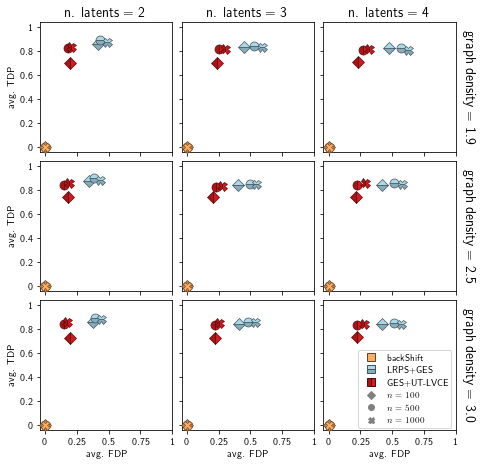

In [13]:
w = 2.5
plt.figure(figsize=(4*w,3*w))
gs = gridspec.GridSpec(3, 4, wspace=0.07, hspace=0.07)
s=14
hs, ds = [2,3,4], [1.9,2.5,3]
for i,k in enumerate(ds):
    for j,h in enumerate(hs):
        plt.subplot(gs[i,j])
        ax = plt.gca()
        legend = ((1,0.65),1) if (i == 2 and j == 2) else None
        plot_roc_I(ax, values_graphs[(h,k)], label_y=(j == 0), label_x=(i==2), xticks=[0, 0.25, 0.5, 0.75, 1], legend=legend)
        ax.set_xlim([-0.04, 1])
        if i == 0:
            #ax.set_title("graph density = %0.1f" % k, size=s)
            ax.set_title("n. latents = %d" % h, size=s)
        if j == 2:
            ax.text(1.1,0.5,"graph density = %0.1f" % k, ha='center', va='center', rotation=270, size=s)
            #ax.text(1.1,0.5,"n. latents = %d" % h, ha='center', va='center', rotation=270, size=s)
# Save plot
plt.savefig("figures/figure_latents_densities.pdf", bbox_inches='tight')

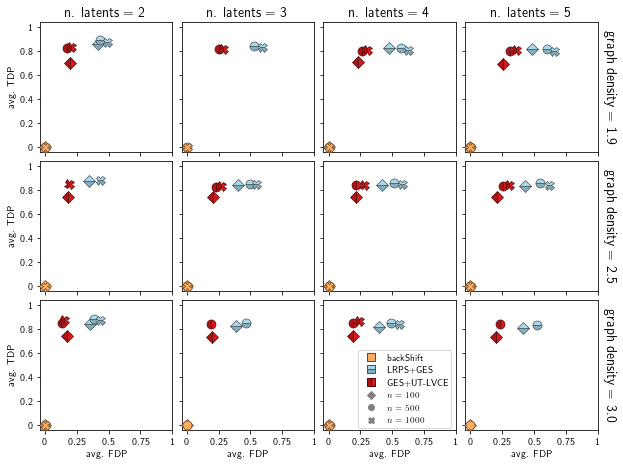

In [26]:
plt.savefig("figures/figure_latents_densities_new_h2345.pdf", bbox_inches='tight')        

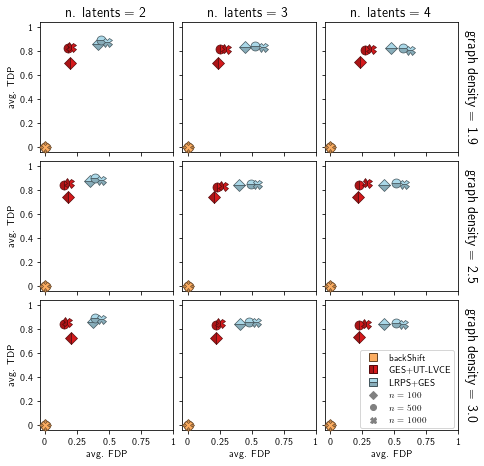

In [13]:
plt.savefig("figures/figure_latents_densities.pdf", bbox_inches='tight')        

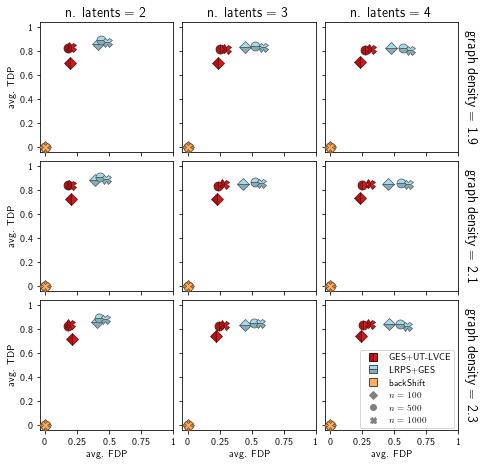

In [54]:
# Save plot
plt.savefig("figures/figure_latents_densities.pdf", bbox_inches='tight')

#### Statistics of the ground truth graphs

In [18]:
import sempler.plot

In [19]:
def unique(list_of_graphs):
    return np.unique(list_of_graphs, axis=0)

def max_degree(list_of_graphs):
    return [utils.degrees(A).max() for A in list_of_graphs]

def avg_degree(list_of_graphs):
    return [utils.degrees(A).mean() for A in list_of_graphs]

def all_degree(list_of_graphs):
    degrees = []
    for A in list_of_graphs:
        degrees += list(utils.degrees(A))
    return degrees

def n_edges(list_of_graphs):    
    return [A.sum() for A in list_of_graphs]

In [20]:
def apply_metric(dict_of_graphs, metric):
    result = {}
    for setting, graphs in dict_of_graphs.items():
        result[setting] = metric(graphs)
    return result

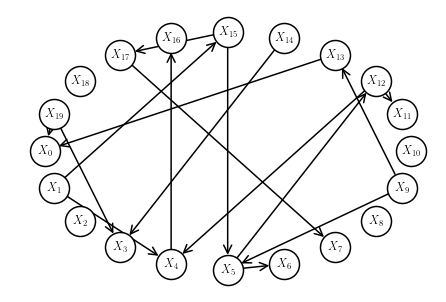

In [24]:
sempler.plot.plot_graph(res[(2,1.9)][0])

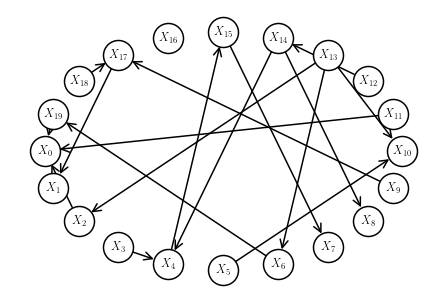

In [25]:
sempler.plot.plot_graph(res[(2,3)][3])

In [27]:
def graph_stats(all_files, debug=True):
    # Iterate over intervention sizes
    true_graphs = {}
    for i,files_size_I in enumerate(all_files):  
        # Iterate over sample sizes
        dict_Ns = {}
        supergraphs_Ns = {}
        size_initial_Ns = {}
        for j,file_n in enumerate(files_size_I):
            args, test_cases, results = read_result(file_n)
            # Check that intervention size is consistent
            if j == 0:
                key = (args.h, args.k)
                print("  h,k =", key) if debug else None
            if j > 0:
                print(key, (args.h, args.k))
                assert key == (args.h, args.k)
            # Iterate over methods            
            #true_imec = [utils.imec(m.A, I) for m,I in test_cases]
            true_graphs[(args.h, args.k)] = [m.A for m,_ in test_cases]
    return true_graphs

In [28]:
res = graph_stats(files)
res = apply_metric(res, unique)

  h,k = (2, 1.9)
(2, 1.9) (2, 1.9)
(2, 1.9) (2, 1.9)
  h,k = (2, 2.5)
(2, 2.5) (2, 2.5)
(2, 2.5) (2, 2.5)
  h,k = (2, 3.0)
(2, 3.0) (2, 3.0)
(2, 3.0) (2, 3.0)
  h,k = (3, 1.9)
(3, 1.9) (3, 1.9)
(3, 1.9) (3, 1.9)
  h,k = (3, 2.5)
(3, 2.5) (3, 2.5)
(3, 2.5) (3, 2.5)
  h,k = (3, 3.0)
(3, 3.0) (3, 3.0)
(3, 3.0) (3, 3.0)
  h,k = (4, 1.9)
(4, 1.9) (4, 1.9)
(4, 1.9) (4, 1.9)
  h,k = (4, 2.5)
(4, 2.5) (4, 2.5)
(4, 2.5) (4, 2.5)
  h,k = (4, 3.0)
(4, 3.0) (4, 3.0)
(4, 3.0) (4, 3.0)


### Number of edges

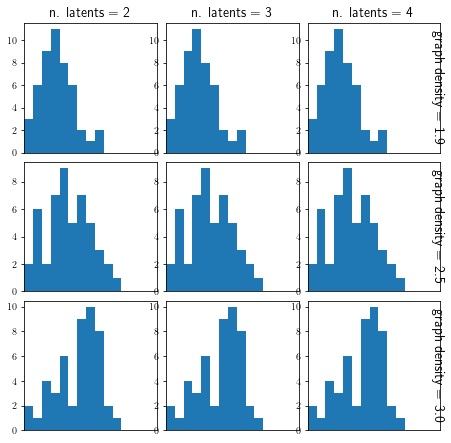

In [35]:
edges = apply_metric(res, n_edges)
w = 2.5
plt.figure(figsize=(4*w,3*w))
gs = gridspec.GridSpec(3, 4, wspace=0.07, hspace=0.07)
s=14
hs, ds = [2,3,4], [1.9,2.5,3]
for i,k in enumerate(ds):
    for j,h in enumerate(hs):
        plt.subplot(gs[i,j])
        ax = plt.gca()        
        plt.hist(edges[(h,k)], np.arange(0,25))
        ax.set_xticks([0,1,2,3,4])
        ax.set_xlim([10,25])
        if i == 0:
            #ax.set_title("graph density = %0.1f" % k, size=s)
            ax.set_title("n. latents = %d" % h, size=s)
        if j == 2:
            ax.set_ylabel("graph density = %0.1f" % k, ha='center', va='top', rotation=270, size=s)
            ax.yaxis.set_label_position("right")
            #ax.text(1.1,0.5,"n. latents = %d" % h, ha='center', va='center', rotation=270, size=s)

### Distr. of average degree

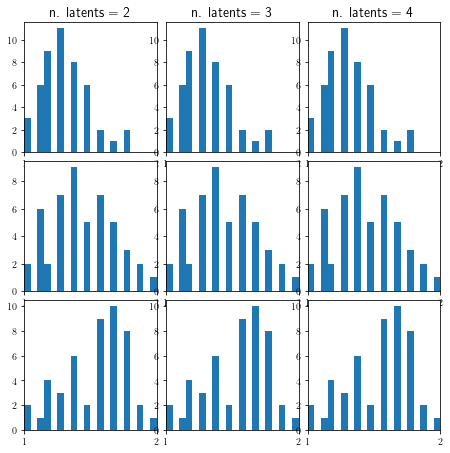

In [38]:
avg_degrees = apply_metric(res, avg_degree)
w = 2.5
plt.figure(figsize=(4*w,3*w))
gs = gridspec.GridSpec(3, 4, wspace=0.07, hspace=0.07)
s=14
hs, ds = [2,3,4], [1.9,2.5,3]
for i,k in enumerate(ds):
    for j,h in enumerate(hs):
        plt.subplot(gs[i,j])
        ax = plt.gca()        
        plt.hist(avg_degrees[(h,k)],bins=np.arange(1,10,0.05))
        ax.set_xticks([0,1,2,3,4])
        ax.set_xlim([1,2])
        if i == 0:
            #ax.set_title("graph density = %0.1f" % k, size=s)
            ax.set_title("n. latents = %d" % h, size=s)
        if j == 3:
            ax.set_ylabel("graph density = %0.1f" % k, ha='center', va='top', rotation=270, size=s)
            ax.yaxis.set_label_position("right")
            #ax.text(1.1,0.5,"n. latents = %d" % h, ha='center', va='center', rotation=270, size=s)

### Distr. of max degree

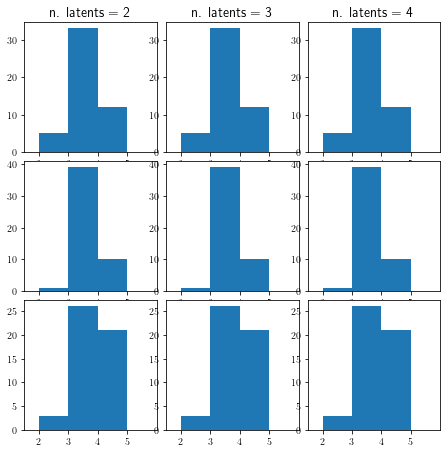

In [42]:
# Plot max degree distribution
max_degrees = apply_metric(res, max_degree)
w = 2.5
plt.figure(figsize=(4*w,3*w))
gs = gridspec.GridSpec(3, 4, wspace=0.07, hspace=0.07)
s=14
hs, ds = [2,3,4], [1.9,2.5,3]
for i,k in enumerate(ds):
    for j,h in enumerate(hs):
        plt.subplot(gs[i,j])
        ax = plt.gca()        
        plt.hist(max_degrees[(h,k)],bins=np.arange(1,10))
        ax.set_xticks([2,3,4,5])
        ax.set_xlim([1.5,6])
        if i == 0:
            #ax.set_title("graph density = %0.1f" % k, size=s)
            ax.set_title("n. latents = %d" % h, size=s)
        if j == 3:
            ax.set_ylabel("graph density = %0.1f" % k, ha='center', va='center', rotation=270, size=s)
            ax.yaxis.set_label_position("right")
            #ax.text(1.1,0.5,"n. latents = %d" % h, ha='center', va='center', rotation=270, size=s)

### Pooled degree distributions

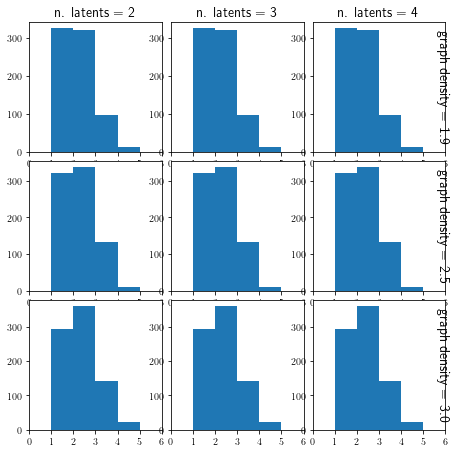

In [43]:
all_degrees = apply_metric(res, all_degree)
w = 2.5
plt.figure(figsize=(4*w,3*w))
gs = gridspec.GridSpec(3, 4, wspace=0.07, hspace=0.07)
s=14
hs, ds = [2,3,4], [1.9,2.5,3]
for i,k in enumerate(ds):
    for j,h in enumerate(hs):
        plt.subplot(gs[i,j])
        ax = plt.gca()        
        plt.hist(all_degrees[(h,k)],bins=np.arange(1,10))
        ax.set_xticks(np.arange(0,10))
        ax.set_xlim([0,6])
        if i == 0:
            #ax.set_title("graph density = %0.1f" % k, size=s)
            ax.set_title("n. latents = %d" % h, size=s)
        if j == 2:
            ax.set_ylabel("graph density = %0.1f" % k, ha='center', va='top', rotation=270, size=s)
            ax.yaxis.set_label_position("right")
            #ax.text(1.1,0.5,"n. latents = %d" % h, ha='center', va='center', rotation=270, size=s)

#### Computation time

In [54]:
files = [[
    "comparison_experiments/results_1694525065__cluster:1_seed:42_tag:hd2l_disc:15_runs:10_m:ubil_min_parents:2_G:50_k:1.9_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:2_e:5_size_I:10_it:0_sl:0_Hs:1,2,3,4_n:100/compiled_results.pickle",
"comparison_experiments/results_1694525419__cluster:1_seed:42_tag:hd2l_disc:15_runs:10_m:ubil_min_parents:2_G:50_k:1.9_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:2_e:5_size_I:10_it:0_sl:0_Hs:1,2,3,4_n:1000/compiled_results.pickle",
"comparison_experiments/results_1694525184__cluster:1_seed:42_tag:hd2l_disc:15_runs:10_m:ubil_min_parents:2_G:50_k:1.9_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:2_e:5_size_I:10_it:0_sl:0_Hs:1,2,3,4_n:500/compiled_results.pickle",
"comparison_experiments/results_1694526072__cluster:1_seed:42_tag:hd2m_disc:15_runs:10_m:ubil_min_parents:2_G:50_k:2.5_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:2_e:5_size_I:10_it:0_sl:0_Hs:1,2,3,4_n:100/compiled_results.pickle",
"comparison_experiments/results_1694526871__cluster:1_seed:42_tag:hd2m_disc:15_runs:10_m:ubil_min_parents:2_G:50_k:2.5_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:2_e:5_size_I:10_it:0_sl:0_Hs:1,2,3,4_n:1000/compiled_results.pickle",
"comparison_experiments/results_1694526346__cluster:1_seed:42_tag:hd2m_disc:15_runs:10_m:ubil_min_parents:2_G:50_k:2.5_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:2_e:5_size_I:10_it:0_sl:0_Hs:1,2,3,4_n:500/compiled_results.pickle",
"comparison_experiments/results_1694537784__cluster:1_seed:42_tag:hd2h_disc:15_runs:10_m:ubil_min_parents:2_G:50_k:3.0_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:2_e:5_size_I:10_it:0_sl:0_Hs:1,2,3,4_n:100/compiled_results.pickle",
"comparison_experiments/results_1694532458__cluster:1_seed:42_tag:hd2h_disc:15_runs:10_m:ubil_min_parents:2_G:50_k:3.0_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:2_e:5_size_I:10_it:0_sl:0_Hs:1,2,3,4_n:1000/compiled_results.pickle",
"comparison_experiments/results_1694532654__cluster:1_seed:42_tag:hd2h_disc:15_runs:10_m:ubil_min_parents:2_G:50_k:3.0_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:2_e:5_size_I:10_it:0_sl:0_Hs:1,2,3,4_n:500/compiled_results.pickle",
]]

In [70]:
def elapsed(all_files, debug=True):
    # Iterate over intervention sizes
    elapsed = {}
    for i,files_size_I in enumerate(all_files):  
        # Iterate over sample sizes        
        for j,file_n in enumerate(files_size_I):
            args, test_cases, results = read_result(file_n)            
            print((args.k, args.n))                              
            elapsed[(args.k, args.n)] = [t for _,_,t in results['ut_lvce_output']]            
    return elapsed

In [71]:
res = elapsed(files)
res

(1.9, 100)
(1.9, 1000)
(1.9, 500)
(2.5, 100)
(2.5, 1000)
(2.5, 500)
(3.0, 100)
(3.0, 1000)
(3.0, 500)


{(1.9, 100): [874.1260137557983,
  1427.0300509929657,
  25655.873188734055,
  6966.6120483875275,
  3438.503983259201,
  3007.2152144908905,
  396.6153826713562,
  9375.103170871735,
  1045.0339560508728,
  6450.5391964912415,
  29181.738203287125,
  1598.5131387710571,
  949.5258016586304,
  4380.389332771301,
  9642.187348604202,
  2148.918154478073,
  3100.3677520751953,
  464.672301530838,
  10887.919498205185,
  2571.3183522224426,
  1043.7334787845612,
  2404.261627674103,
  2783.019301891327,
  3232.9985797405243,
  613.0443377494812,
  3245.9231843948364,
  2782.8527505397797,
  531.7028961181641,
  416.70893001556396,
  3569.6774003505707,
  3031.5006477832794,
  1969.7684397697449,
  1124.4844524860382,
  2356.571320295334,
  3415.578832626343,
  2067.1409475803375,
  1033.0434205532074,
  426.2272889614105,
  448.98491287231445,
  2705.9543533325195,
  5662.401562929153,
  273.2564718723297,
  1328.636076927185,
  7532.495972394943,
  2784.6781656742096,
  1572.105542182922

In [85]:
print("Average computation time for h=2")
for n in [100,500,1000]:
    print(f"  n={n}")
    for k in [1.9, 2.5, 3]:        
        print(f"    {k}: {np.mean(res[(k,n)])}")

Average computation time for h=2
  n=100
    1.9: 3262.429614417076
    2.5: 3251.100812699318
    3: 6920.620845530033
  n=500
    1.9: 2897.297365848541
    2.5: 2276.687939953804
    3: 2700.179804299831
  n=1000
    1.9: 3078.4025825481413
    2.5: 2237.1936860084534
    3: 2705.463309100628


In [78]:
n = 500
np.mean(res[(1.9,n)]), np.mean(res[(2.5,n)]), np.mean(res[(3,n)])

(2897.297365848541, 2276.687939953804, 2700.179804299831)

In [79]:
n = 1000
np.mean(res[(1.9,n)]), np.mean(res[(2.5,n)]), np.mean(res[(3,n)])

(3078.4025825481413, 2237.1936860084534, 2705.463309100628)